In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

# Features Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

# SMOTE
from imblearn.over_sampling import ADASYN

# Normal Test
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Perfomances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

In [2]:
# Keras ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
'''
Authors: 
Andrea Pimpinella <andrea.pimpinella@polimi.it>,
Alessandro E. C. Redondi <alessandroenrico.redondi@polimi.it>
Antonio Capone  <alessandroenrico.redondi@polimi.it>

This code preprocesses raw data and perform features extraction for Prediction Model of Video Quality Long Term QoE
use case.
'''

'\nAuthors: \nAndrea Pimpinella <andrea.pimpinella@polimi.it>,\nAlessandro E. C. Redondi <alessandroenrico.redondi@polimi.it>\nAntonio Capone  <alessandroenrico.redondi@polimi.it>\n\nThis code preprocesses raw data and perform features extraction for Prediction Model of Video Quality Long Term QoE\nuse case.\n'

In [4]:
#USEFUL FUNCTIONS FOR PLOTTING

def plot_cdf(data, votes, bin_edges, ax, xlabel=None, color=None):

    '''
    This function is useful to understand whether in inout feature "data" there is information which is correlated to the
    satisfaction of the users.
    Generally speaking, the meaning of the CDFs is that, if there is a gap between the distributions of the data
    conditioned to the satisfaction class of the corresponding users, it means that the information in the data is
    correlated to users satisfaction and thus can be learnt by a supervised classifier.
    Generally speaking, looking at data distributions is the first step to decide whether some data may be useful or
    not for ML problems.
    :param data: data to be plot (one-dimensional array)
    :param votes: satisfaction labels, int; if already binary, set threshold to None
    :param bin_edges: array of type  np.linspace(min(data), max(data), num_bins+1)
    :param ax: axis of type plt.subplots(figsize=(a,b));
    :param xlabel: label to gice to x axis
    :param color: axis color
    :return:
    '''

    if xlabel is None:
        xlabel = 'your data'
    if color is None:
        color = 'black'

    yt = votes.copy()

    neg, _ = np.histogram(data[yt == +1], bins=bin_edges)  # count number of evidences per bin
    pos, _ = np.histogram(data[yt == 0], bins=bin_edges)

    sumpos =  sum(pos)
    sumneg =  sum(neg)
    pos = pos.astype(float) / sumpos  # normalize to total number of evidences
    neg = neg.astype(float) / sumneg

    xrange = bin_edges[1:] - bin_edges[:1]
    
    title = 'CDF'
    ax.plot(xrange, np.cumsum(pos))
    ax.plot(xrange, np.cumsum(neg))
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)
    ax.tick_params(axis='x', colors=color)
    ax.tick_params(axis='y', colors=color)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_title(title, color=color)
    ax.legend(['High QoE', 'Low QoE'])
    return

# USEFUL FUNCTIONS FOR PREDICTION

def hyperparameter_tuning(train_sample, train_target, names, classifiers, parameters_grid,
                          n_splits_in=None, ref_metric=None):
    '''
    This function applies a cross validation strategy to select, for each of the classifiers provided in input, 
    the best hyper-parameters (hp) values out of a pool of candidate values (Grid Search Procedure). 
    The function saves on a file the best hp values, for the input Training Fold. Finally, it returns the prediction 
    performance on the input Validation Fold.
    (ref: https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

    :param train_sample: training samples set
    :param train_target: training users satisfaction labels
    :param test_sample: test samples set
    :param test_target: test users satisfaction labels
    :param names: involved classifiers names
    :param classifiers: involved classifiers scikitlearn functions
    :param n_splits_in: number of k fold splits for validation (our results were derived with 10 folds, which is the default value)
    :param ref_metric: optimization metric (sklearn.metrics); default roc_auc
    :return: prediction performance on the test set (AUC)
    '''

    if ref_metric is None:
        ref_metric = 'roc_auc'
    if n_splits_in is None:
        n_splits_in = 2

    best_hp = pd.DataFrame(index = names, columns = ['BestHP_Values'])
    print('Choose Best hyper-parameters through Cross Validation')
    text_file = open('Best_hyper-parameters (HP Tuning).txt', "w") # If this filename already exists in folder, 
    # results will be appended to older file. Delete older version to fill a new txt file.
    text_file.write("############\n")
    for name, clf in zip(names, classifiers):
        text_file.write("{}:\n".format(name))
        print("############")
        print(' Classifier {} - Processing'.format(name))
        grid = parameters_grid[names.index(name)] #take hyper-parameters candidate values grid 
        
        estimator = model_selection.GridSearchCV(clf, grid, scoring=ref_metric,refit=True, n_jobs=-1, verbose=2,
                                                 cv=n_splits_in).fit(train_sample, train_target) #Grid Search 
        bp = estimator.best_params_
        print(' Best Parameters Values: {}'.format(bp))
        print(list(bp.values()))
        best_hp.at[name,'BestHP_Values'] = list(bp.values())
        text_file.write("{}:\n".format(estimator.best_params_))
        text_file.write("############\n")
        print("############")
    text_file.write("******************\n")
    text_file.close()

    return best_hp
    

def direct_prediction(train_sample, train_target, test_sample, test_target, names, classifiers):
    '''
    This function takes in input a group of classifiers with already fixed HP values, train them on the input data 
    train_sample --> train_target and finally performs prediction on the input test_sample-->test_target. 
    
    Note that each classifier outputs the probability that a given test user belongs to the
    class of Dissatisfied Users. By thresholding such probability, one can effectively assign to the test user 
    either the Satisfied ('0') or the Dissatisfied ('1') label. Computing the FPR and TPR of the classifier for 
    different threshold values, it is possible to draw a ROC Curve.
    Finally, the performance in terms of Area Under the ROC Curve are returned as output.
    (ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
    
    
    :param train_sample: training samples set
    :param train_target: training users satisfaction labels
    :param test_sample: test samples set
    :param test_target: test users satisfaction labels
    :param names: names of the considered classifiers 
    :param classifiers: the scikit methods corresponding to the considered classifiers
    :return: prediction performance (AUC) on the test set
    '''
    
    perf = pd.DataFrame(index=names,columns=['AUC'])
    prediction_proba = np.empty((len(names), len(test_sample)))

    plt.figure(figsize=(20, 5))
    color = ['b', 'r', 'g', 'c', 'k', 'm'] #choose a color for each classifier
    color = color[:len(names)]
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.3) # ROC Curve of a dummy 
    # Classifier
    for name, clf in zip(names, classifiers):
        print(' Classifier {} - Fit & Predict'.format(name))
        estimator = clf.fit(train_sample, train_target) # fit the classifier on training set

        prediction_proba[names.index(name),:] = estimator.predict_proba(test_sample)[:, 1] # generate, for each test
        # user, the probability that the user is not satisfied

        fpr, tpr, decision_thresholds = metrics.roc_curve(test_target, prediction_proba[names.index(name),:]
                                                          , pos_label=1)

        perf.at[name,'AUC'] = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color[names.index(name)], label=r'ROC %s (AUC = %0.3f)' % (name,perf.loc[name,
                                                                                                          'AUC']), lw=2, alpha=.8)
        perf.at[name,'AUC'] = metrics.auc(fpr, tpr)
    
    plt.plot(0, 1, '*', color='k', label=r'Optimum: FPR = 0, TPR = 1', lw=2, alpha=.8, markersize=15)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xlabel('False Positive Rate', color='black', fontsize=14)
    plt.ylabel('True Positive Rate', color='black', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig('ROC.png', bbox_inches='tight') #uncomment to save the plot
    return perf


        

# Import Training Data

In [5]:
if 'dataset' in globals():
    del dataset
if 'ground_truth' in globals():
    del ground_truth

path = '' # PUT YOUR FILE PATH
basic_train = pd.read_csv(path+'BasicDataset_Training_MRN.csv')

dataset = basic_train.drop(['User_Satisfaction','Unnamed: 0', 'Unnamed: 0.1'], axis=1)
ground_truth = basic_train.loc[:, 'User_Satisfaction'].copy()
print('Train Data:', dataset.shape)
print('Train Target:', ground_truth.shape)



Train Data: (18970, 12)
Train Target: (18970,)


In [6]:
list(dataset.columns)
dataset.head()

,Cumulative_YoutubeSess_LTE_DL_Time,Cumulative_YoutubeSess_LTE_DL_Volume,Cumulative_YoutubeSess_UMTS_DL_Time,Cumulative_YoutubeSess_UMTS_DL_Volume,Max_RSRQ,Max_SNR,Cumulative_Full_Service_Time_UMTS,Cumulative_Lim_Service_Time_UMTS,Cumulative_No_Service_Time_UMTS,Cumulative_Full_Service_Time_LTE,Cumulative_Lim_Service_Time_LTE,Cumulative_No_Service_Time_LTE
0,100.727,110854.0,0.000,0.0,-6.0,27.8,53917,5636,2043,213227,3996,2883
1,9.324,93.0,0.000,0.0,-3.0,-19.8,85021,1761,1223,87700,4287,1251
2,2715.406,2271118.0,580.907,63891.0,-3.0,-19.8,123462,4664,2715,203846,5776,8748
3,74.097,39065.0,0.000,0.0,-4.0,-19.8,85675,4903,1322,7924,1799,9491
4,168.955,41933.0,0.000,0.0,-3.0,-19.9,104902,2068,669,137121,3846,937


In [7]:
ground_truth.value_counts()
ground_truth.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: User_Satisfaction, dtype: float64

# Data Visualization

In [8]:
# Here Plot and PreProcess Data for a first Overview and Preliminary Analysis

#Visual Tools: Data Distribution, etc.

General Informations on the dataset

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18970 entries, 0 to 18969
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Cumulative_YoutubeSess_LTE_DL_Time     18970 non-null  float64
 1   Cumulative_YoutubeSess_LTE_DL_Volume   18970 non-null  float64
 2   Cumulative_YoutubeSess_UMTS_DL_Time    18970 non-null  float64
 3   Cumulative_YoutubeSess_UMTS_DL_Volume  18970 non-null  float64
 4   Max_RSRQ                               18970 non-null  float64
 5   Max_SNR                                18970 non-null  float64
 6   Cumulative_Full_Service_Time_UMTS      18970 non-null  int64  
 7   Cumulative_Lim_Service_Time_UMTS       18970 non-null  int64  
 8   Cumulative_No_Service_Time_UMTS        18970 non-null  int64  
 9   Cumulative_Full_Service_Time_LTE       18970 non-null  int64  
 10  Cumulative_Lim_Service_Time_LTE        18970 non-null  int64  
 11  Cu

List of Features

In [10]:
print('Number of columns: ', len(dataset.columns))

for col in list(dataset.columns):
    print('\t',col)

Number of columns:  12
	 Cumulative_YoutubeSess_LTE_DL_Time
	 Cumulative_YoutubeSess_LTE_DL_Volume
	 Cumulative_YoutubeSess_UMTS_DL_Time
	 Cumulative_YoutubeSess_UMTS_DL_Volume
	 Max_RSRQ
	 Max_SNR
	 Cumulative_Full_Service_Time_UMTS
	 Cumulative_Lim_Service_Time_UMTS
	 Cumulative_No_Service_Time_UMTS
	 Cumulative_Full_Service_Time_LTE
	 Cumulative_Lim_Service_Time_LTE
	 Cumulative_No_Service_Time_LTE


Look for the presence of null values in the dataset

In [11]:
dataset.isnull().sum()

Cumulative_YoutubeSess_LTE_DL_Time       0
Cumulative_YoutubeSess_LTE_DL_Volume     0
Cumulative_YoutubeSess_UMTS_DL_Time      0
Cumulative_YoutubeSess_UMTS_DL_Volume    0
Max_RSRQ                                 0
Max_SNR                                  0
Cumulative_Full_Service_Time_UMTS        0
Cumulative_Lim_Service_Time_UMTS         0
Cumulative_No_Service_Time_UMTS          0
Cumulative_Full_Service_Time_LTE         0
Cumulative_Lim_Service_Time_LTE          0
Cumulative_No_Service_Time_LTE           0
dtype: int64

## Visualize Satisfaction Distribution

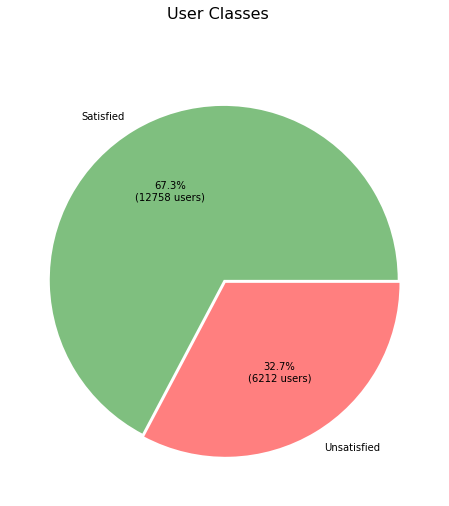

In [12]:
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} users)".format(pct, absolute)

# Create a pie plot to visualize how the many rows of the dataset belongs to each satisfaction class
satisfied_users = ground_truth[ground_truth==0].shape[0]
unsatisfied_users = ground_truth[ground_truth==1].shape[0]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.suptitle('User Classes', fontsize=16)

data = [satisfied_users, unsatisfied_users]
labels = 'Satisfied', 'Unsatisfied'
colors = 'g','r'
_ = ax.pie(data, labels=labels, colors=colors, explode=(0.01,0.01), autopct=lambda pct: func(pct, data), wedgeprops={'alpha':0.5})


Despite the grouping of QoE values, the two classes 'Satisfied'(0) and 'Unsatisfied'(1) remain imbalanced.

## Visualize Feature's Probability Distributions

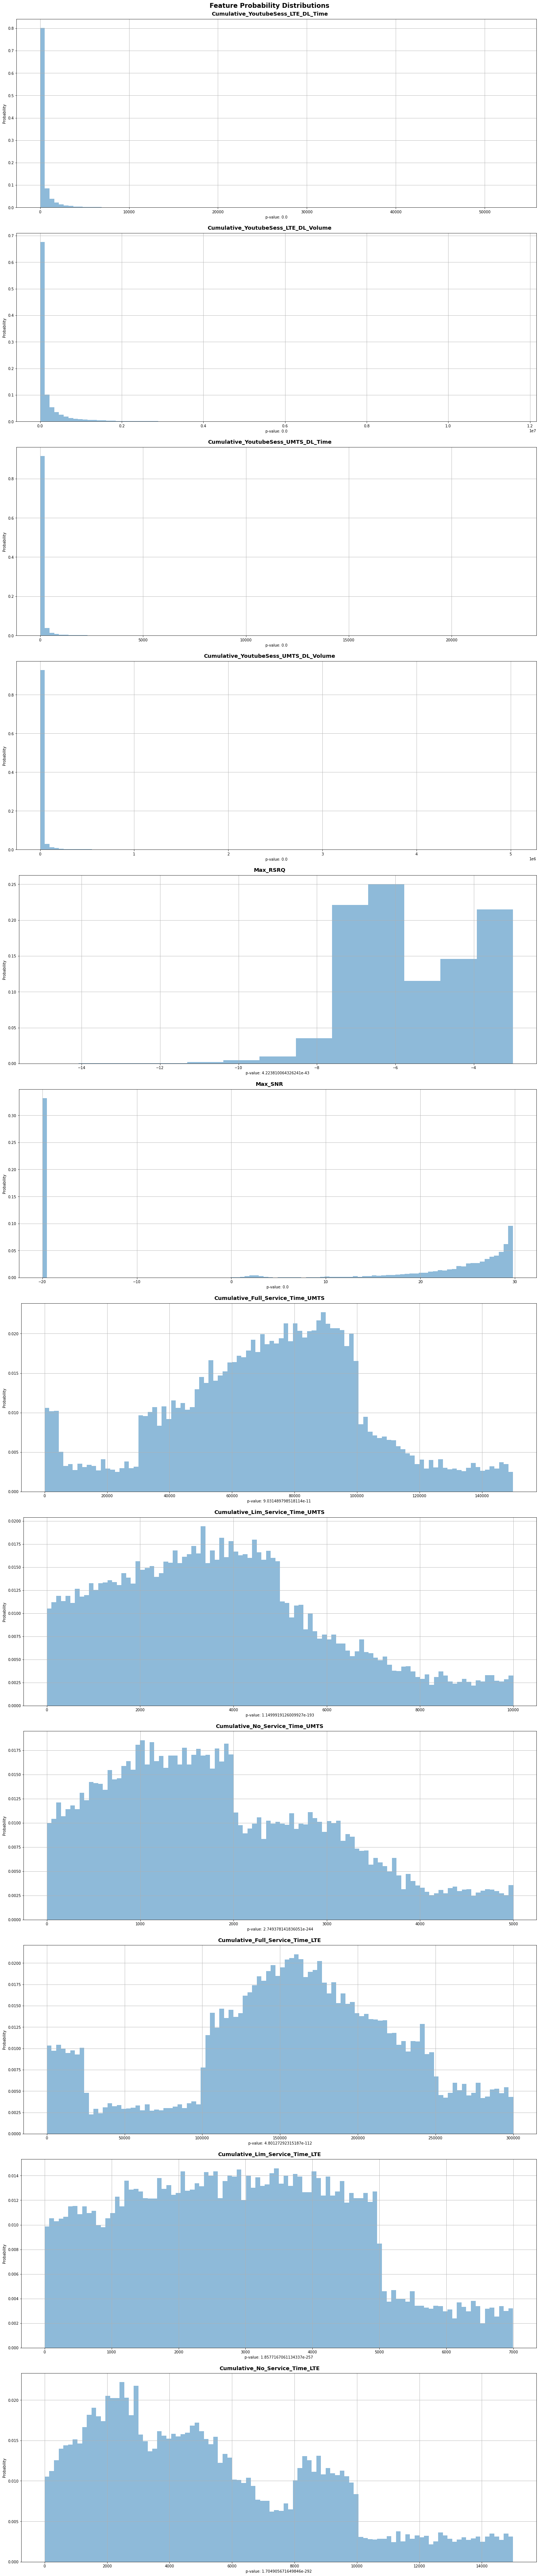

In [13]:
# Plot Probability Distribution of features

fig = plt.figure(constrained_layout=True, figsize=(20, 8*len(dataset.columns)))
fig.suptitle('Feature Probability Distributions', fontsize='xx-large', fontweight='extra bold')

subfigs = fig.subfigures(nrows=len(dataset.columns), ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(dataset.columns[row], fontsize='x-large', fontweight='bold')
    
    # Select the specific feature of the dataset
    x = dataset[dataset.columns[row]]
    ax = subfig.subplots(nrows=1, ncols=1)
    
    # Compute bar weights to obatin a bar plot such that all the bar heigths sums to 1
    weights = np.ones_like(x) / len(x)
    
    # Adjust the number of bins to plot
    n_bins = 100
    if dataset.columns[row] == 'Max_RSRQ':
        n_bins = int(x.max()-x.min())+1
    
    ax.hist(x, weights=weights, alpha=0.5, bins=n_bins, histtype='stepfilled')
   
    ax.set_ylabel('Probability')
    ax.set_xlabel('p-value: ' + str(normaltest(x)[1]))
    
    ax.grid(visible=True)

## Visualize Feature's Probability Distributions conditioned to the satisfactory class

Since the number of Satisfied and Unsatisfied users is different, hist plots are run with density=True argument in order to plot the probability density of the data (area normalized to 1 with stacked=True).

In [14]:
# Extract indexes of satsfied and unsatisfied users
satisfied_index = ground_truth[ground_truth==0].index
unsatisfied_index = ground_truth[ground_truth==1].index

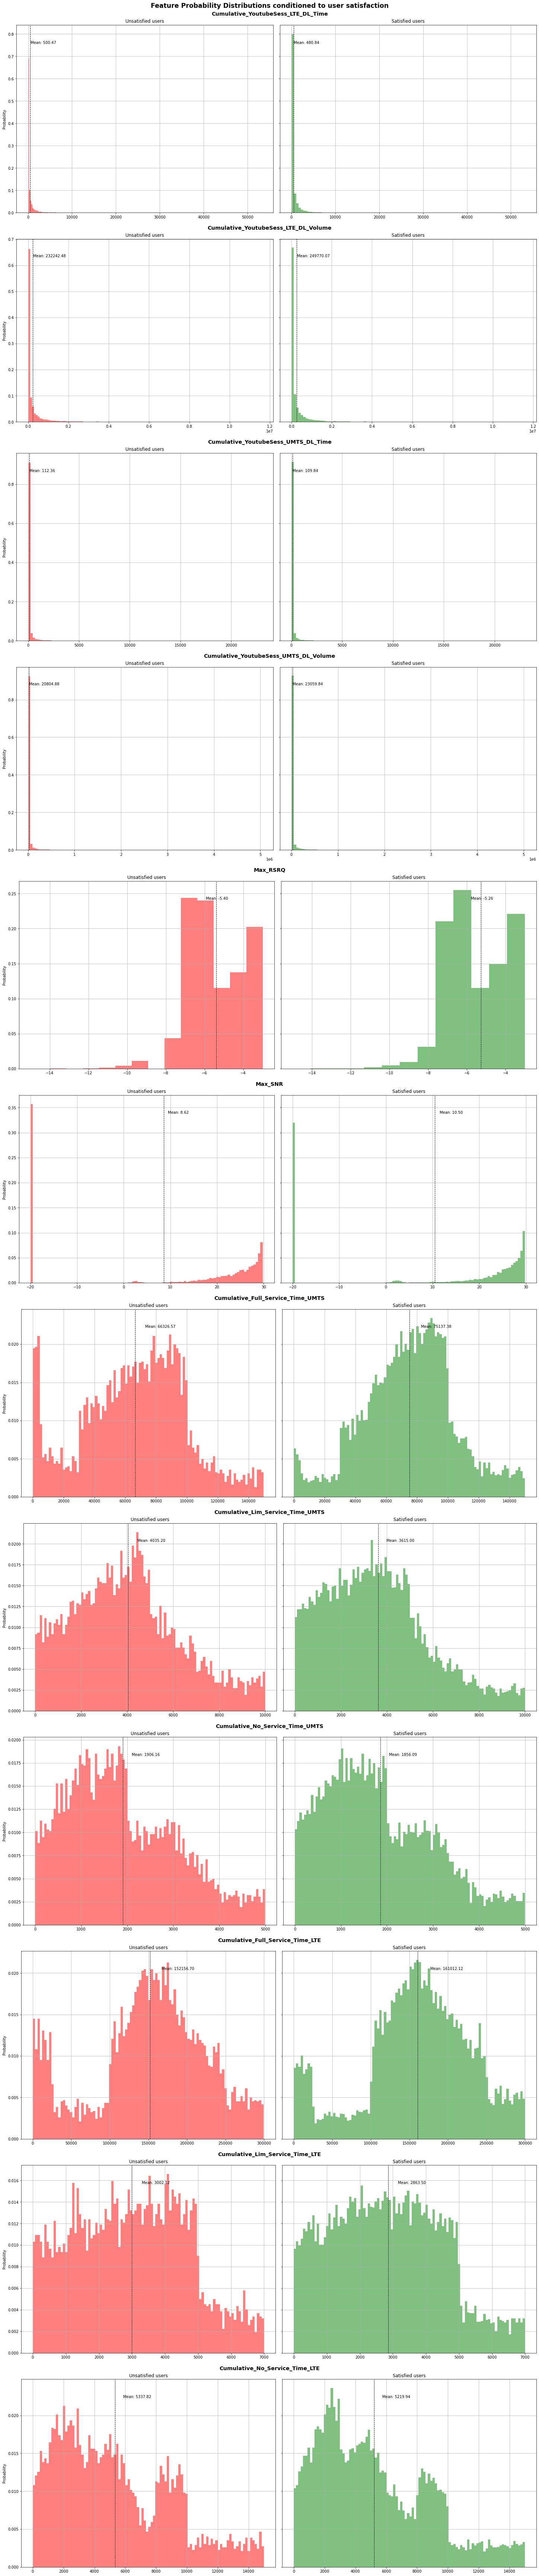

In [15]:
# Plot Distribution of features based on the user satisfaction

fig = plt.figure(constrained_layout=True, figsize=(20, 8*len(dataset.columns)))
fig.suptitle('Feature Probability Distributions conditioned to user satisfaction', fontsize='xx-large', fontweight='extra bold')


# create len(dataset.columns)x1 subpfigs
subfigs = fig.subfigures(nrows=len(dataset.columns), ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(dataset.columns[row], fontsize='x-large', fontweight='bold')
    
    x = dataset[dataset.columns[row]]
    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharex='row', sharey='row')
    
    # Compute bar weights to obatin a bar plot such that all the bar heigths sums to 1
    weights0 = np.ones_like(x[x.index.isin(unsatisfied_index)]) / len(x[x.index.isin(unsatisfied_index)])
    weights1 = np.ones_like(x[x.index.isin(satisfied_index)]) / len(x[x.index.isin(satisfied_index)])
    
    # Adjust the number of bins to plot
    n_bins = 100
    if dataset.columns[row] == 'Max_RSRQ':
        n_bins = int(x.max()-x.min())+1
        
    tmp_0 = axs[0].hist(x[x.index.isin(unsatisfied_index)], weights=weights0, bins=n_bins, color='red', alpha=0.5)
    tmp_1 = axs[1].hist(x[x.index.isin(satisfied_index)], weights=weights1, bins=n_bins, color='green', alpha=0.5)
    
    axs[0].set_title('Unsatisfied users')
    axs[1].set_title('Satisfied users')
    axs[0].set_ylabel('Probability')
    
    # Mean
    axs[0].axvline(x[x.index.isin(unsatisfied_index)].mean(), color='k', linestyle='dashed', linewidth=1)
    axs[1].axvline(x[x.index.isin(satisfied_index)].mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = axs[0].get_ylim()
    axs[0].text(x[x.index.isin(unsatisfied_index)].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x[x.index.isin(unsatisfied_index)].mean()))
    axs[1].text(x[x.index.isin(satisfied_index)].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(x[x.index.isin(satisfied_index)].mean()))
    
    for ax in axs.flat:
        ax.grid(visible=True)

Nearly half of features are not gaussian distributed, we have to transform them to better fit the normal distribution.

# Features Engineering

In [16]:
# Here Create Features: transform basic features (if needed), create new features, exclude unnecessary
# features (i.e., those which are not correlated with target)

#Visual Tools: Conditional CDFs with respect to user lables, Conditional Pair-Wise ScatterPlots, etc.  
#Mathematical Tools: Mathematical Ttransformations, Features-Target Correlation Analysis, etc.

## Conditional CDFs with respect to user lables

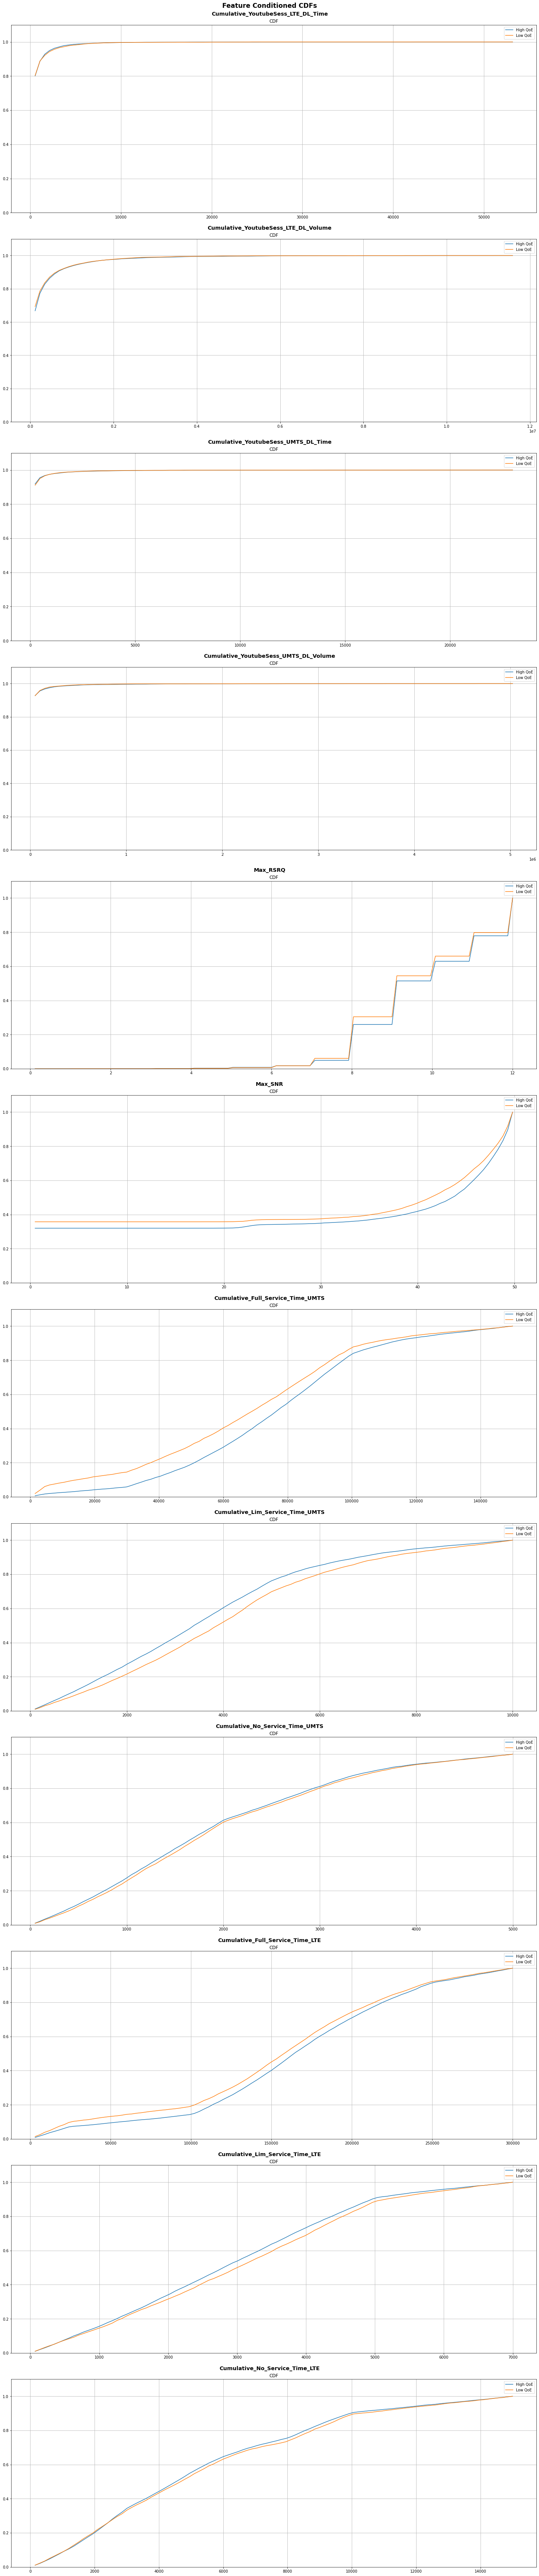

In [17]:
# Plot Conditional CDFs of the features

fig = plt.figure(constrained_layout=True, figsize=(20, 8*len(dataset.columns)))
fig.suptitle('Feature Conditioned CDFs', fontsize='xx-large', fontweight='extra bold')


subfigs = fig.subfigures(nrows=len(dataset.columns), ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(dataset.columns[row], fontsize='x-large', fontweight='bold')
    
    x = dataset[dataset.columns[row]]
    y = ground_truth.copy()
    ax = subfig.subplots(nrows=1, ncols=1)
    ax.set_ylim([0, 1.1])
    bin_edges = np.linspace(min(x), max(x), 101) #define bins to use for plotting the marginal cdfs
    
    plot_cdf(x, y, bin_edges, ax, xlabel='')
    
    ax.grid(visible=True)

By looking at the conditioned CDFs, the Cumulative_YoutubeSess_LTE_DL_Time, Cumulative_YoutubeSess_LTE_DL_Volume, Cumulative_YoutubeSess_UMTS_DL_Time, Cumulative_YoutubeSess_UMTS_DL_Volume, Cumulative_No_Service_Time_UMTS and Cumulative_No_Service_Time_LTE turns out to be bad features since the gap between the two CDF curves is almost imperceptible.

## Pearson Correlation

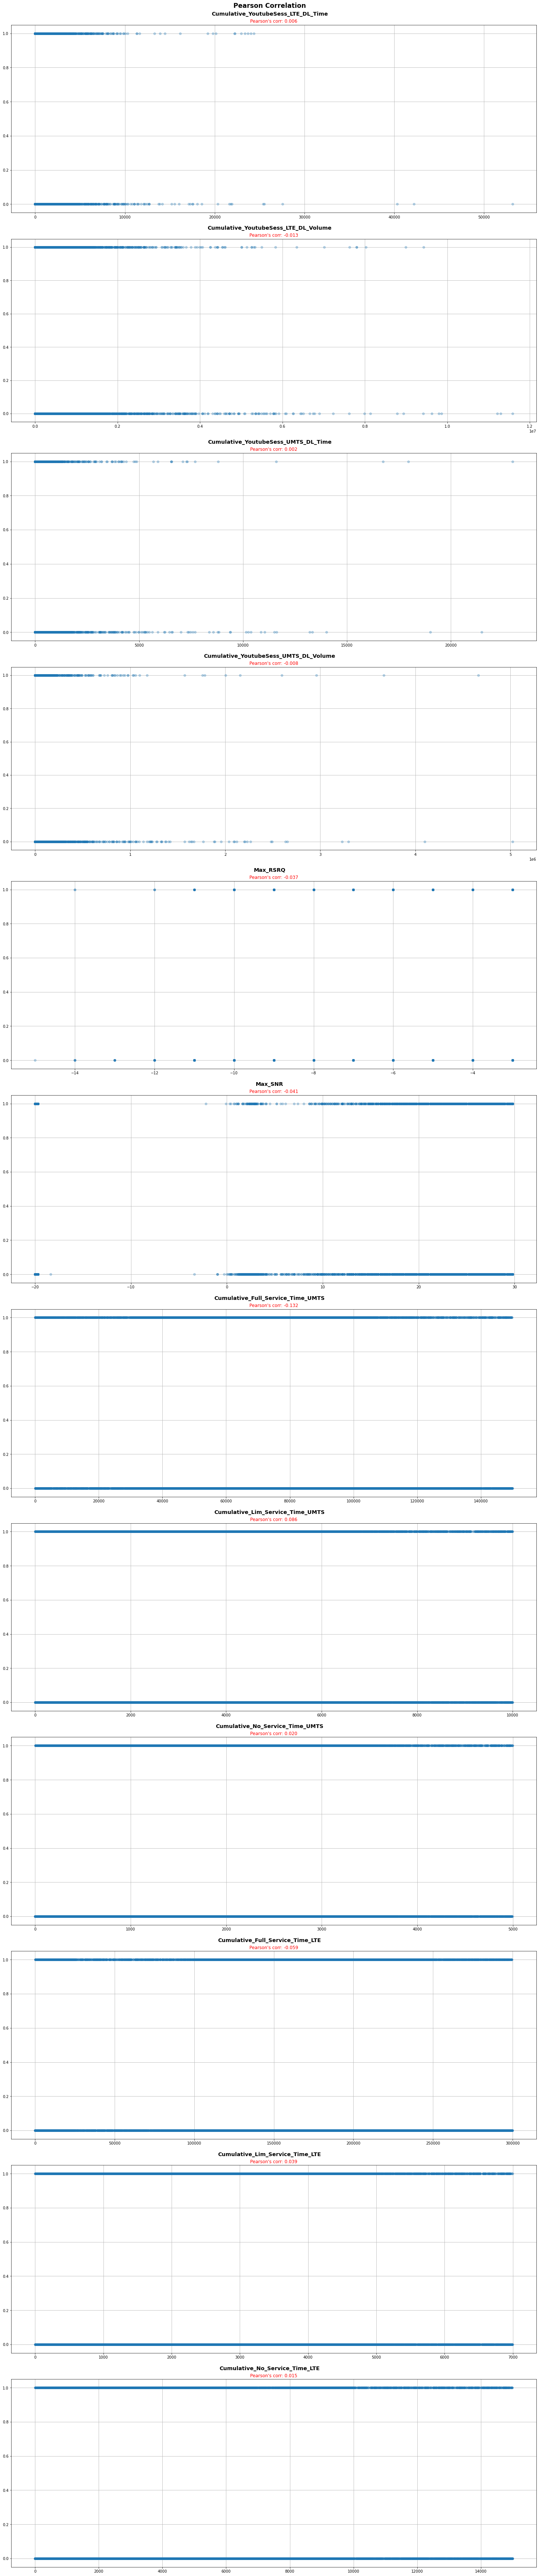

In [18]:
# Show Pearson Correlation Coefficient Between Cum. Full Service Time in LTE vs Users Satisfaction


fig = plt.figure(constrained_layout=True, figsize=(20, 8*len(dataset.columns)))
fig.suptitle('Pearson Correlation', fontsize='xx-large', fontweight='extra bold')


subfigs = fig.subfigures(nrows=len(dataset.columns), ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(dataset.columns[row], fontsize='x-large', fontweight='bold')
    
    x = dataset[dataset.columns[row]]
    y = ground_truth.copy()
    ax = subfig.subplots(nrows=1, ncols=1)
    ax.plot(x, y, 'o', alpha=0.3)
    ax.set_title("Pearson's corr: {:.3f}".format(x.corr(y)), color='red')
    ax.grid(visible=True)

## Feature Combination

### Percentage of Service Time spent on Youtube

Assuming that the more enjoyable is the service, the more likely you are to spend time with it

In [19]:
def add_yt_percentage(dataset):
    time_spent_on_YT = dataset['Cumulative_YoutubeSess_LTE_DL_Time'] + dataset['Cumulative_YoutubeSess_UMTS_DL_Time']

    time_spent_on_service = dataset['Cumulative_Full_Service_Time_UMTS'] + dataset['Cumulative_Lim_Service_Time_UMTS'] + dataset['Cumulative_No_Service_Time_UMTS'] + dataset['Cumulative_Full_Service_Time_LTE'] + dataset['Cumulative_Lim_Service_Time_LTE'] + dataset['Cumulative_No_Service_Time_LTE']

    dataset['Percentage_Service_Time_on_YoutubeSess'] = time_spent_on_YT / time_spent_on_service

    # Handle division by zero by setting them feature to 0
    dataset.loc[~np.isfinite(dataset['Percentage_Service_Time_on_YoutubeSess']), 'Percentage_Service_Time_on_YoutubeSess'] = 0

    return dataset

### Average rate on Youtube

Higher rates allow better video quality and less buffer undeflows

In [20]:
def add_yt_avg_rate(dataset):
    volume_on_YT = dataset['Cumulative_YoutubeSess_UMTS_DL_Volume'] + dataset['Cumulative_YoutubeSess_LTE_DL_Volume']
    time_on_YT = dataset['Cumulative_YoutubeSess_UMTS_DL_Time'] + dataset['Cumulative_YoutubeSess_LTE_DL_Time'] 


    dataset['Average_Youtube_Rate'] = volume_on_YT / time_on_YT
    
    # Handle division by zero by setting them feature to 0
    dataset.loc[~np.isfinite(dataset['Average_Youtube_Rate']), 'Average_Youtube_Rate'] = 0
    
    return dataset

### No Service Time Percentage

The more time a user is in no service, the more he will be more likely to have low QoE

In [21]:
def add_no_service_percentage(dataset):
    no_service_time = dataset['Cumulative_No_Service_Time_UMTS'] + dataset['Cumulative_No_Service_Time_LTE']
    total_time = dataset['Cumulative_Full_Service_Time_UMTS'] + dataset['Cumulative_Lim_Service_Time_UMTS'] + dataset['Cumulative_No_Service_Time_UMTS'] + dataset['Cumulative_Full_Service_Time_LTE'] + dataset['Cumulative_Lim_Service_Time_LTE'] + dataset['Cumulative_No_Service_Time_LTE']
    
    dataset['No_Service_Percentage'] = no_service_time / total_time
    
    return dataset

### Full Service Time Percentage

The more time a user is in full service, the more he will be more likely to have high QoE

In [22]:
def add_full_service_percentage(dataset):
    full_service_time = dataset['Cumulative_Full_Service_Time_UMTS'] + dataset['Cumulative_Full_Service_Time_LTE']
    total_time = dataset['Cumulative_Full_Service_Time_UMTS'] + dataset['Cumulative_Lim_Service_Time_UMTS'] + dataset['Cumulative_No_Service_Time_UMTS'] + dataset['Cumulative_Full_Service_Time_LTE'] + dataset['Cumulative_Lim_Service_Time_LTE'] + dataset['Cumulative_No_Service_Time_LTE']
    
    dataset['Full_Service_Percentage'] = full_service_time / total_time
    
    return dataset

### Limited Service Time Percentage

In [23]:
def add_limited_service_percentage(dataset):
    full_service_time = dataset['Cumulative_Lim_Service_Time_UMTS'] + dataset['Cumulative_Lim_Service_Time_LTE']
    total_time = dataset['Cumulative_Full_Service_Time_UMTS'] + dataset['Cumulative_Lim_Service_Time_UMTS'] + dataset['Cumulative_No_Service_Time_UMTS'] + dataset['Cumulative_Full_Service_Time_LTE'] + dataset['Cumulative_Lim_Service_Time_LTE'] + dataset['Cumulative_No_Service_Time_LTE']
    
    dataset['Lim_Service_Percentage'] = full_service_time / total_time
    
    return dataset

### LTE Service Percentage

In [24]:
def add_lte_service_percentage(dataset):
    lte_service_time = dataset['Cumulative_Full_Service_Time_LTE'] + dataset['Cumulative_Lim_Service_Time_LTE'] + dataset['Cumulative_No_Service_Time_LTE']
    total_time = dataset['Cumulative_Full_Service_Time_UMTS'] + dataset['Cumulative_Lim_Service_Time_UMTS'] + dataset['Cumulative_No_Service_Time_UMTS'] + dataset['Cumulative_Full_Service_Time_LTE'] + dataset['Cumulative_Lim_Service_Time_LTE'] + dataset['Cumulative_No_Service_Time_LTE']
    
    dataset['LTE_Service_Percentage'] = lte_service_time / total_time
    
    return dataset

### Add new features

In [25]:
# Calls all the feature adding functions
def add_new_features(data):
    data = add_yt_avg_rate(data)
    #data = add_yt_percentage(data)
    data = add_no_service_percentage(data)
    data = add_full_service_percentage(data)
    data = add_lte_service_percentage(data)
    data = add_limited_service_percentage(data)
    return data

In [26]:
print('Dataset shape before adding features: {}'.format(dataset.shape))
starting_columns = dataset.columns
dataset = add_new_features(dataset)
print('Dataset shape after adding features: {}'.format(dataset.shape))

added_columns = list(set(dataset.columns) - set(starting_columns))

Dataset shape before adding features: (18970, 12)
Dataset shape after adding features: (18970, 17)


In [27]:
added_columns

['No_Service_Percentage',
 'Lim_Service_Percentage',
 'Average_Youtube_Rate',
 'Full_Service_Percentage',
 'LTE_Service_Percentage']

#### Analyze the new Features

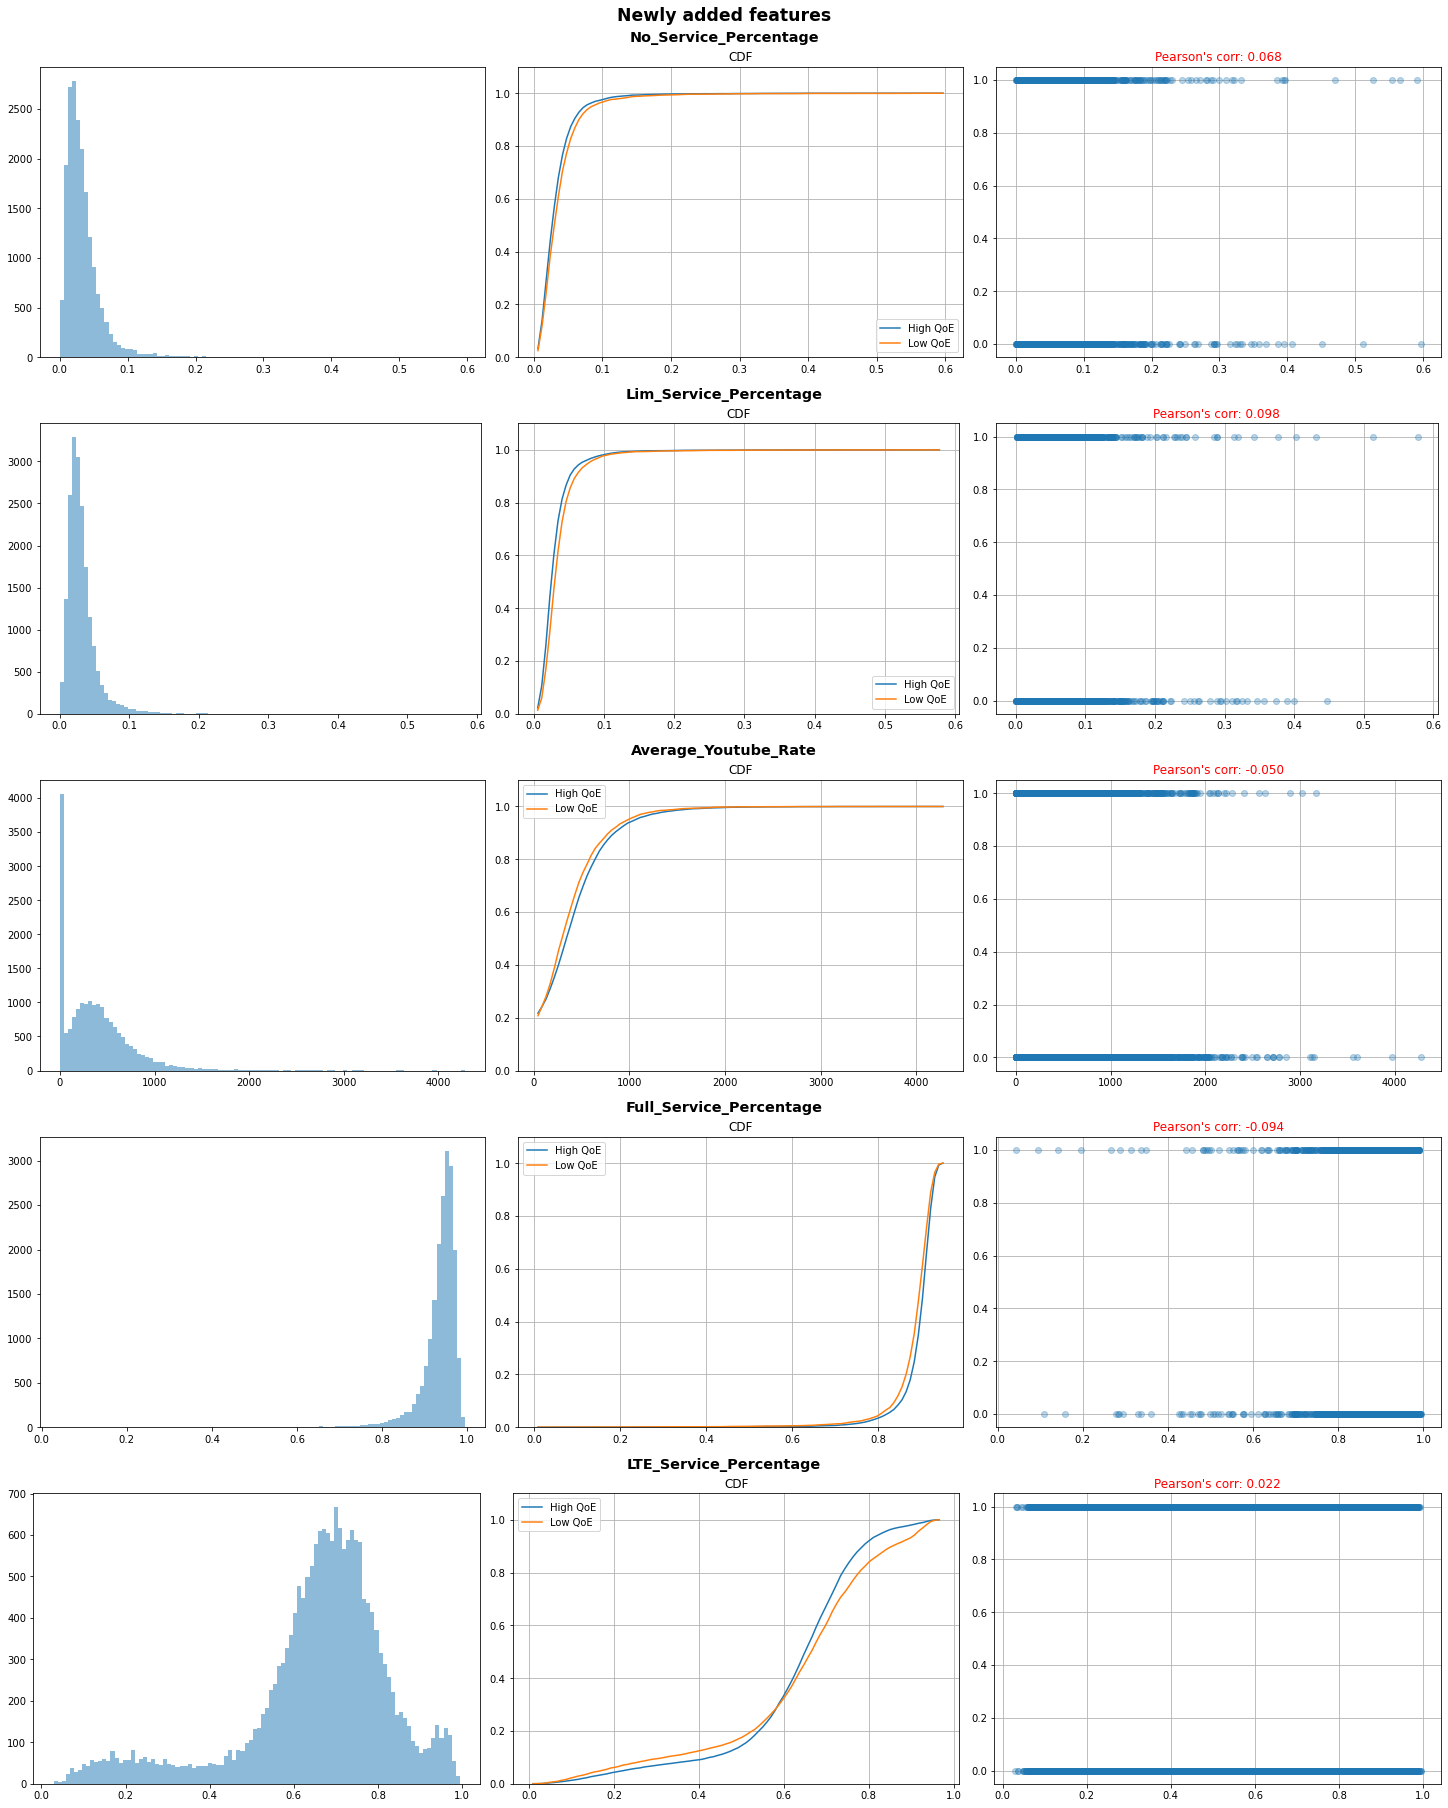

In [28]:
# Plot Conditional CDFs of the features

fig = plt.figure(constrained_layout=True, figsize=(20, 5*len(added_columns)))
fig.suptitle('Newly added features', fontsize='xx-large', fontweight='extra bold')


subfigs = fig.subfigures(nrows=len(added_columns), ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(added_columns[row], fontsize='x-large', fontweight='bold')
    
    x = dataset[added_columns[row]]
    y = ground_truth.copy()
    axs = subfig.subplots(nrows=1, ncols=3)
    axs[0].hist(x, bins=100, alpha=0.5)

    axs[1].set_ylim([0, 1.1])
    bin_edges = np.linspace(min(x), max(x), 101) #define bins to use for plotting the marginal cdfs
    plot_cdf(x, y, bin_edges, axs[1], xlabel='')

    axs[2].plot(x, y, 'o', alpha=0.3)
    axs[2].set_title("Pearson's corr: {:.3f}".format(x.corr(y)), color='red')

    plt.grid(visible=True)

Percentage_Service_Time_on_YoutubeSess feature does not seems to be a good feature: low variance, not gaussian shaped and overlapped CDF distributions

## Feature Transformation

Let's a build a function which visualizes the same feature under different transforamtions, to select which one to choose to have a distribution as close as possible to a Gaussian.

In [29]:
# Given a a set of values (pd.Series) to transform and the functions (list) to apply on it,
# it return the transformed column. The parameter fit_col is used by PowerTransformer in case
# the fitting values are different from the transformed one (in case of test set)

def apply_transformation(col, transformations, fit_col):
    temp = col
    temp_fit = fit_col
    
    for trans in transformations:
        if trans == PowerTransformer.transform:
            pt = PowerTransformer()
            pt.fit(temp_fit.array.reshape(-1, 1))
            temp = trans(pt, temp.array.reshape(-1, 1))
        elif trans == np.log: # move dataset by an offset to avoid 0s
            temp = trans(temp + abs(temp_fit.min()) + 1)
            temp_fit = trans(temp_fit + abs(temp_fit.min()) + 1)
        elif trans == np.reciprocal: # move dataset by an offset to avoid 0s
            temp = trans(temp + abs(temp_fit.min()) + 1)
            temp_fit = trans(temp_fit + abs(temp_fit.min()) + 1)
        elif trans == np.exp:
            if temp.max() > 1000: # to avoid infinity values
                temp = trans(temp / (temp_fit.max() / 100))
                temp_fit = trans(temp_fit / (temp_fit.max() / 100))
            else:
                temp_fit = trans(temp_fit)
        elif trans == np.sqrt: # to avoid sqrt of zero or negative values 
            temp = trans(temp + abs(temp_fit.min()) + 1)
            temp_fit = trans(temp_fit + abs(temp_fit.min()) + 1)
        else:
            temp = trans(temp)
            temp_fit = trans(temp_fit)
    
    return temp   

In [30]:
# Given a column (pd.Series), this function applies a series of predefined transformations to the column
# and it plots their distribution.
# It can be used to evaluate if and which transformation to apply to the feature

def plot_transformed_feature(col):
    
    # Set of predefined transformations
    transformations = [[np.exp], [np.log], [np.sqrt], [np.reciprocal], [np.exp, PowerTransformer.transform], [np.reciprocal, PowerTransformer.transform], [np.log, PowerTransformer.transform], [np.sqrt, PowerTransformer.transform], [PowerTransformer.transform]]
    fig, ax = plt.subplots(nrows=len(transformations)+1, figsize=(15, 8*len(transformations)+1))
    
    fig.suptitle(col.name)
    
    initial_p = normaltest(col)[1]
    
    ax[0].hist(col, bins=100, alpha=0.5)
    ax[0].set_xlabel(initial_p)
    ax[0].set_title('No transformations')
    
    for ind, set_trans in enumerate(transformations):
        
        temp = apply_transformation(col, set_trans, col)
        
        temp_p = normaltest(temp)[1]
        
        ax[ind+1].hist(temp, bins=100, alpha=0.5)
        ax[ind+1].set_xlabel(temp_p)
        ax[ind+1].set_title(set_trans)
        
    plt.show()
            
    

In [32]:
dataset.columns

Index(['Cumulative_YoutubeSess_LTE_DL_Time',
       'Cumulative_YoutubeSess_LTE_DL_Volume',
       'Cumulative_YoutubeSess_UMTS_DL_Time',
       'Cumulative_YoutubeSess_UMTS_DL_Volume', 'Max_RSRQ', 'Max_SNR',
       'Cumulative_Full_Service_Time_UMTS', 'Cumulative_Lim_Service_Time_UMTS',
       'Cumulative_No_Service_Time_UMTS', 'Cumulative_Full_Service_Time_LTE',
       'Cumulative_Lim_Service_Time_LTE', 'Cumulative_No_Service_Time_LTE',
       'Average_Youtube_Rate', 'No_Service_Percentage',
       'Full_Service_Percentage', 'LTE_Service_Percentage',
       'Lim_Service_Percentage'],
      dtype='object')

D:\Users\giaco\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
D:\Users\giaco\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
D:\Users\giaco\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
D:\Users\giaco\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
D:\Users\giaco\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar inste

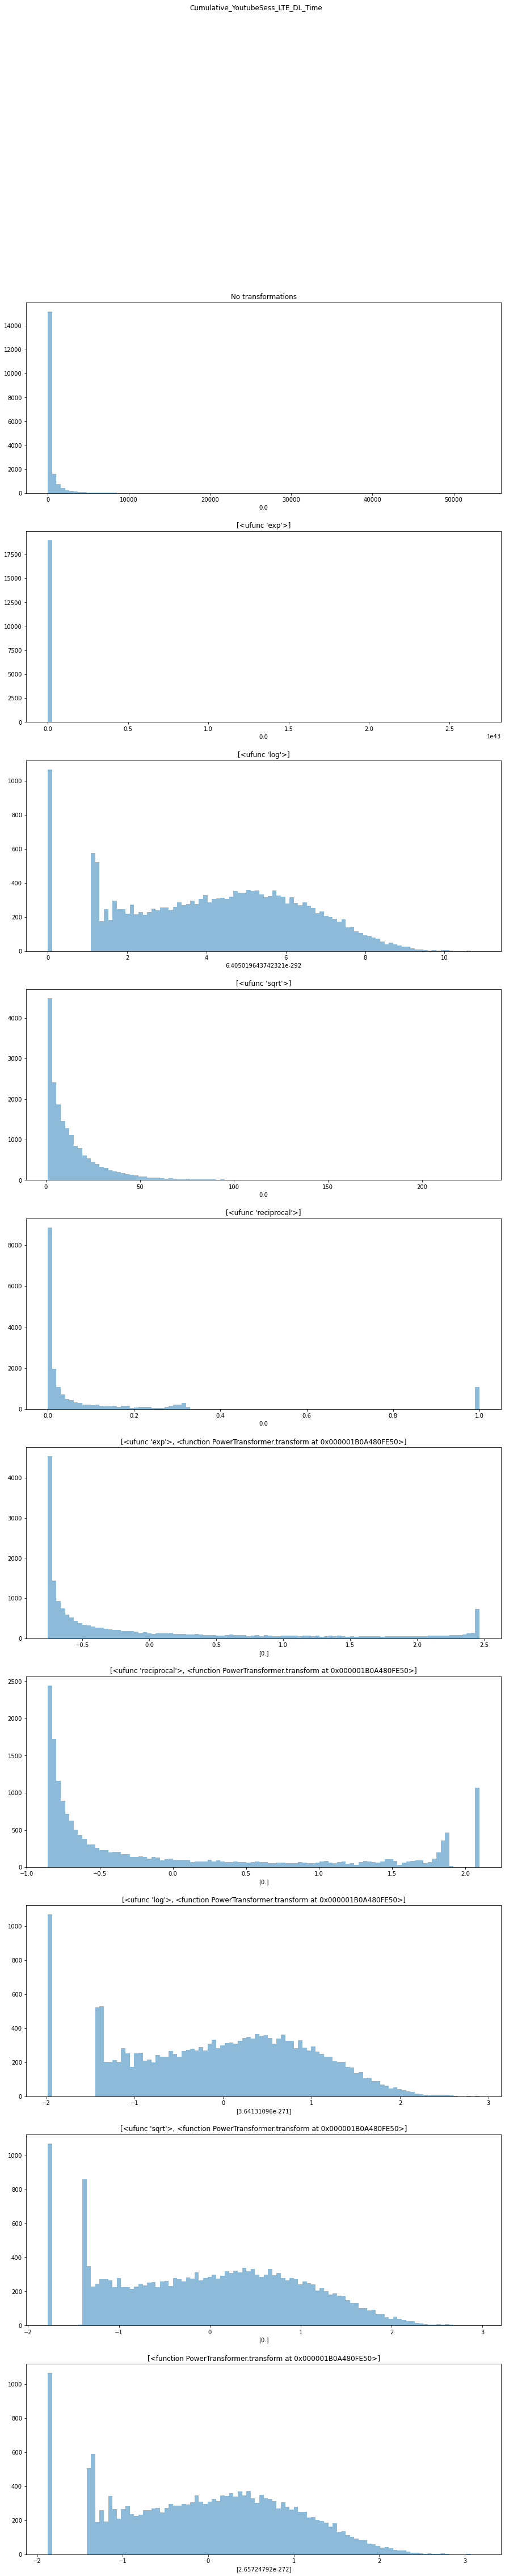

In [33]:
# Check which of the predefinied transformations better fit the gaussian distribution
col_to_examine = 'Cumulative_YoutubeSess_LTE_DL_Time'
plot_transformed_feature(dataset[col_to_examine])

In [34]:
# Set of transformations to apply to the dataset
selected_transformations = [
    ['Cumulative_YoutubeSess_LTE_DL_Time', [np.log]],
    ['Cumulative_YoutubeSess_LTE_DL_Volume', [np.log]],
    # ['Cumulative_YoutubeSess_UMTS_DL_Time', [np.log]], # no way to obtain a Gaussian shaped distribution
    #['Cumulative_YoutubeSess_UMTS_DL_Volume', [np.log]], # no way to obtain a Gaussian shaped distribution
    # Max_RSRQ good as it is
    # Max_SNR no way to obtain a Gaussian shaped distribution
    # Cumulative_Full_Service_Time_UMTS good as it is
    #['Cumulative_Lim_Service_Time_UMTS', [np.sqrt]], discarded lower p value
    #['Cumulative_No_Service_Time_UMTS', [np.sqrt]], discarded lower p value
    #['Cumulative_Full_Service_Time_LTE', [np.sqrt]], discarded lower p value
    #['Cumulative_Lim_Service_Time_LTE', [np.sqrt]], discarded lower p value
    #['Cumulative_No_Service_Time_LTE', [np.sqrt]], discarded lower p value
    # ['Average_Youtube_Rate', [np.log]],
    # Percentage_Service_Time_on_YoutubeSess seems to have no way to distribute it
    ['Full_Service_Percentage', [lambda x: - np.log(1 - x)]],
    ['Lim_Service_Percentage', [lambda x: - np.log(1 - x)]],
    ['No_Service_Percentage', [lambda x: - np.log(1 - x)]]
]

In [35]:
# keep a copy of original dataset, useful in test phase
original_dataset = dataset.copy()

# Transform the dataset
for col, trans in selected_transformations:
    dataset[col] = apply_transformation(dataset[col], trans, dataset[col])

### Plot newly transformed features

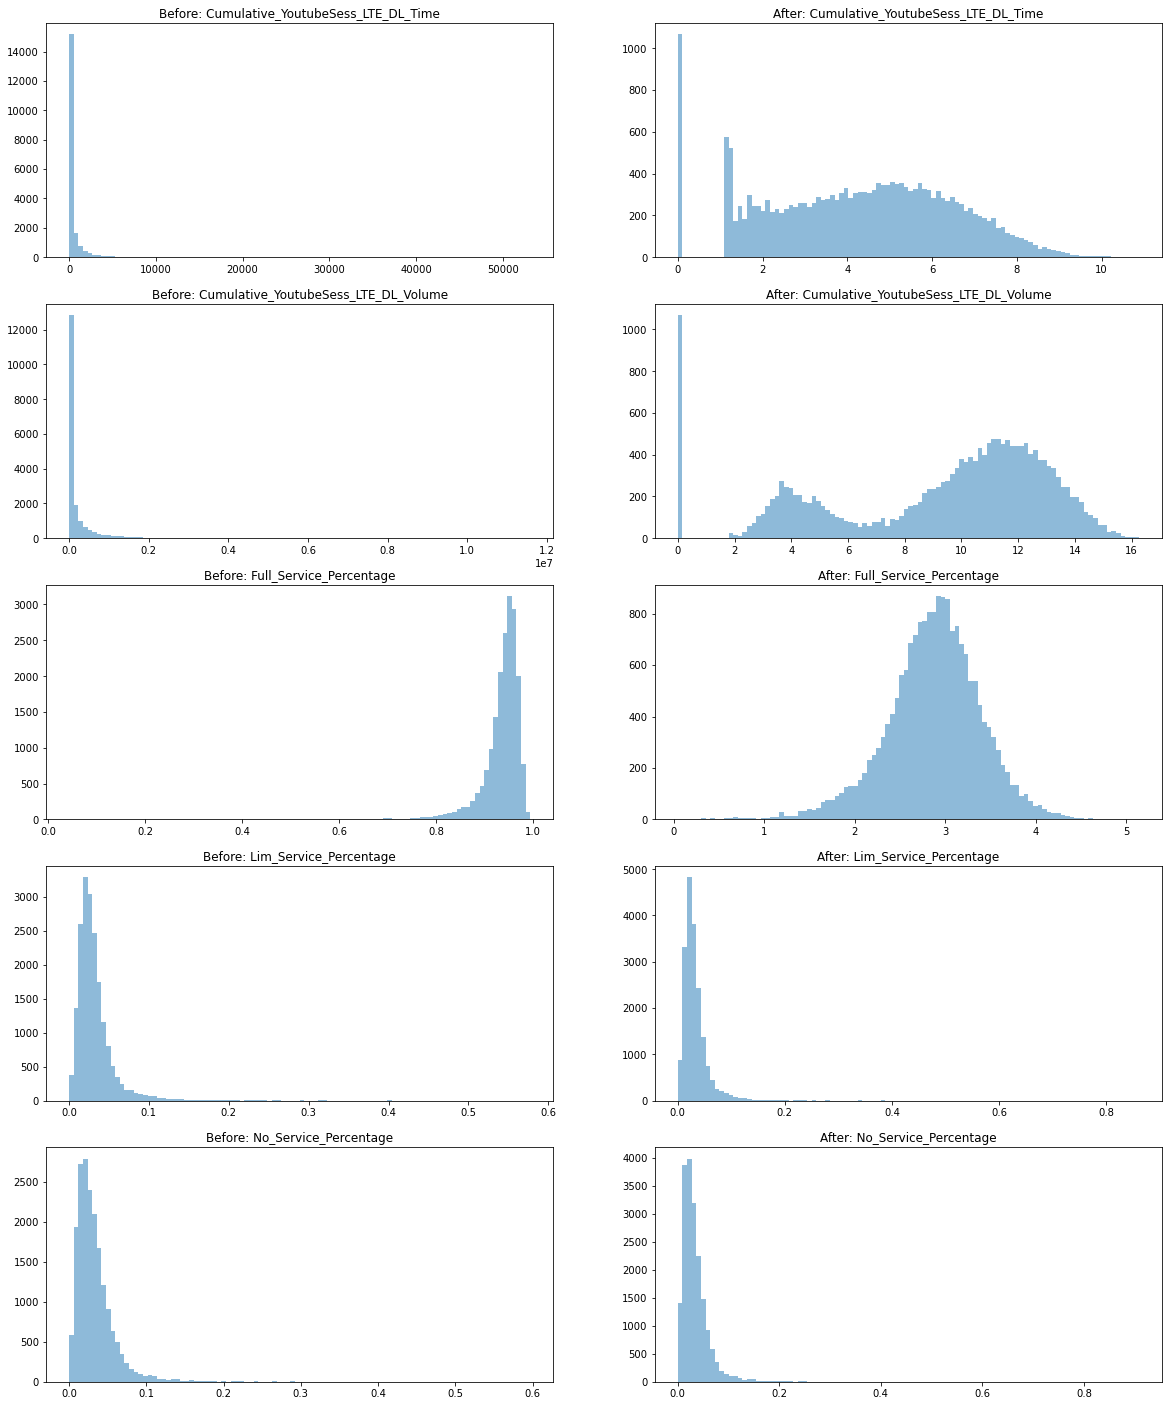

In [36]:
fig, axs = plt.subplots(ncols=2, nrows=len(selected_transformations), figsize=(20, 5*len(selected_transformations)))

for ind in range(len(selected_transformations)):
    col_name = selected_transformations[ind][0]
    axs[ind][0].hist(original_dataset[col_name], bins=100, alpha=0.5)
    axs[ind][0].set_title('Before: '+col_name)
    axs[ind][1].hist(dataset[col_name], bins=100, alpha=0.5)
    axs[ind][1].set_title('After: '+col_name)
    

## Features Selection

In [37]:
def low_pearson_corr_features(dataset, ground_truth, thr):
    
    print("Features with Pearson Correlation <=", thr, ':')
    selected_features = []
    for col in dataset.columns:
        if abs(dataset[col].corr(ground_truth)) <= thr:
            print('\t',col, dataset[col].corr(ground_truth))
            selected_features.append(col)
    return selected_features

In [38]:
def select_from_model(dataset, ground_truth, estimator, max_features_to_keep=None):
    print("Features with low importance lower in "+estimator.__class__.__name__)
    # Scale the dataset
    scaled_dataset = pd.DataFrame(StandardScaler().fit_transform(dataset), columns=dataset.columns)
    # Fit the model
    estimator.fit(dataset, ground_truth)
    model = SelectFromModel(estimator, prefit=True, threshold='mean', max_features=max_features_to_keep)
    # Retrieve features with lwoer importance
    feature_idx = ~np.array(model.get_support())
    selected_features = dataset.columns[feature_idx]
    for f in selected_features:
        print('\t',f)
    return selected_features


In [39]:
def keep_only_new_added_features(dataset, ground_truth, added_features):
    print("Only newly added features will be kept")
    
    print("Dropped Features are:")
    features_to_remove = list(set(dataset.columns) - set(added_features))
    for f in features_to_remove:
        print('\t',f)
    return features_to_remove
    

In [40]:
_ = low_pearson_corr_features(dataset, ground_truth, 0.015)
print('\n')
estimator = LinearSVC(class_weight='balanced')
_ = select_from_model(dataset, ground_truth, estimator)
print('\n')
_ = keep_only_new_added_features(dataset, ground_truth, added_columns)

Features with Pearson Correlation <= 0.015 :
	 Cumulative_YoutubeSess_LTE_DL_Time 0.004147187252799044
	 Cumulative_YoutubeSess_LTE_DL_Volume 0.002952009648225827
	 Cumulative_YoutubeSess_UMTS_DL_Time 0.0018987670133808084
	 Cumulative_YoutubeSess_UMTS_DL_Volume -0.00780505543263989


Features with low importance lower in LinearSVC
	 Cumulative_YoutubeSess_LTE_DL_Time
	 Cumulative_YoutubeSess_UMTS_DL_Volume
	 Cumulative_Full_Service_Time_UMTS
	 Cumulative_Lim_Service_Time_UMTS
	 Cumulative_No_Service_Time_UMTS
	 Cumulative_Full_Service_Time_LTE
	 Cumulative_Lim_Service_Time_LTE
	 Cumulative_No_Service_Time_LTE
	 Average_Youtube_Rate
	 No_Service_Percentage
	 Full_Service_Percentage
	 LTE_Service_Percentage
	 Lim_Service_Percentage


Only newly added features will be kept
Dropped Features are:
	 Cumulative_Lim_Service_Time_LTE
	 Cumulative_Full_Service_Time_UMTS
	 Cumulative_YoutubeSess_UMTS_DL_Volume
	 Cumulative_YoutubeSess_LTE_DL_Time
	 Cumulative_Lim_Service_Time_UMTS
	 Cumulative_N

D:\Users\giaco\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
selection_method = 1

# --- Method 0 ---
if selection_method == 0: # No features are dropped
    print('Method 0 has been chosen: do not drop the features')
    features_to_drop = []
    
# --- Method 1 ---
elif selection_method == 1: # Features with Pearson's Correlation Coefficient <= 0.015
    print('Method 1 has been chosen: Pearson Correlation Coefficient')
    threshold = 0.015
    features_to_drop = low_pearson_corr_features(dataset, ground_truth, threshold)
    print('\n')
    
# --- Method 2 ---
elif selection_method == 2:
    print('Method 2 has been chosen: select_from_model')
    estimator = LinearSVC(class_weight='balanced')
    features_to_drop = select_from_model(dataset, ground_truth, estimator)
    print('\n')

# --- Method 3 ---
elif selection_method == 3:
    print('Method 3 has been chosen: keep only newly added')
    features_to_drop = keep_only_new_added_features(dataset, ground_truth, added_columns)
    
# Drop the features
dataset.drop(columns=features_to_drop, inplace=True)

print(dataset.shape)


Method 1 has been chosen: Pearson Correlation Coefficient
Features with Pearson Correlation <= 0.015 :
	 Cumulative_YoutubeSess_LTE_DL_Time 0.004147187252799044
	 Cumulative_YoutubeSess_LTE_DL_Volume 0.002952009648225827
	 Cumulative_YoutubeSess_UMTS_DL_Time 0.0018987670133808084
	 Cumulative_YoutubeSess_UMTS_DL_Volume -0.00780505543263989


(18970, 13)


## SMOTE

In [ ]:
def oversample(dataset, ground_truth):
    sm = ADASYN(sampling_strategy=0.8, random_state=42)
    X_res, y_res = sm.fit_resample(dataset, ground_truth)
    new_dataset = pd.DataFrame(X_res, columns = dataset.columns)
    new_groundtruth = pd.Series(y_res, name = ground_truth.name)
    return new_dataset, new_groundtruth

In [ ]:
print('Initial shape', dataset.shape)
# Combining Oversampling and undersampling seems to be more effective
dataset, ground_truth = oversample(dataset, ground_truth)
print('After SMOTE shape', dataset.shape)

# Prediction Pipeline

## Data Normalization

In [42]:
## NORMALISE DATA
mean = dataset.mean(axis=0)
std = dataset.std(axis=0)
scaled_dataset = (dataset - mean) / std

# Print Info
print(20*'*')
print('% of Class 1 in Training : ', len(ground_truth[ground_truth == 1]) / len(ground_truth),
      '; % of Class 0 in Training: ', len(ground_truth[ground_truth == 0]) / len(ground_truth))
print('Shape Training Set :', scaled_dataset.shape, ',', scaled_dataset.shape)
print(20*'*')

********************
% of Class 1 in Training :  0.3274644175013179 ; % of Class 0 in Training:  0.6725355824986822
Shape Training Set : (18970, 13) , (18970, 13)
********************


## Select ML Classifiers, HP Candidate Values and K-Fold Validation Structure

In [43]:
# Choose k of K-Fold Validation Procedure
splits = 2

# Select ML Classifiers
names = ["Logistic Regression", "KNeighborsClassifier", "RandomForestClassifier", "MLPClassifier"]

raw_classifiers = [
    #: LR model has 1 Hyper-Parameter, which is the regularisaton coefficient C. Its value should be tuned according to a K-Fold Validation Procedure.
    LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42), 
    KNeighborsClassifier(n_jobs=-1, weights='distance', metric='manhattan'),
    RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced', bootstrap=True, max_features='sqrt'),
    MLPClassifier(max_iter=200, random_state=42)
] 

# Choose Hyper-Parameters Candidate Values 
parameters_grid = [
    { #LR: in this example a grid search is performed over a set of 3 candidate values for hyper-parameter C
        'C': [0.1,1,5]
    },
    { #KNN
        'n_neighbors' : [1,2,5,7,9,11,13,15],
    },
    { # RFC
        'max_depth': [10, 50, 100, None],
        'min_samples_leaf': [1, 2, 4, 15],
        'min_samples_split': [2, 5, 10, 20],
        'n_estimators': [200] # takes too much time with more estimators
    },
    { #MLPC
        'hidden_layer_sizes': [(10,), (50,), (100,50)],
        'activation': ['tanh'],#'activation': ['tanh', 'relu', 'logistic'],
        'solver': ['adam'], #'solver': ['sgd', 'adam']
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']
    }
]


## Tune ML Classifiers through a K-Fold Validation

In [44]:
# Select Best Hyperparameter Value for This Fold
t0 = time.time()

hp_values = hyperparameter_tuning(scaled_dataset, ground_truth, names, 
                      raw_classifiers, parameters_grid, n_splits_in=splits)

t1 = time.time()

print('Hyperparameter Tuning took {}s to be executed'.format(t1-t0))
hp_values.head()

Choose Best hyper-parameters through Cross Validation
############
 Classifier Logistic Regression - Processing
Fitting 2 folds for each of 3 candidates, totalling 6 fits
 Best Parameters Values: {'C': 0.1}
[0.1]
############
############
 Classifier KNeighborsClassifier - Processing
Fitting 2 folds for each of 8 candidates, totalling 16 fits
 Best Parameters Values: {'n_neighbors': 15}
[15]
############
############
 Classifier RandomForestClassifier - Processing
Fitting 2 folds for each of 64 candidates, totalling 128 fits
 Best Parameters Values: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 200}
[10, 4, 20, 200]
############
############
 Classifier MLPClassifier - Processing
Fitting 2 folds for each of 12 candidates, totalling 24 fits
 Best Parameters Values: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
['tanh', 0.05, (50,), 'constant', 'adam']
############
Hyperparameter Tunin

,BestHP_Values
Logistic Regression,[0.1]
KNeighborsClassifier,[15]
RandomForestClassifier,"[10, 4, 20, 200]"
MLPClassifier,"[tanh, 0.05, (50,), constant, adam]"


## Loading Test Set and Preprocessing

In [45]:
# Import Test Data
basic_test = pd.read_csv(path+'BasicDataset_Test_MRN.csv')
dataset_test = basic_test.drop(['User_Satisfaction','Unnamed: 0', 'Unnamed: 0.1'], axis=1)
ground_truth_test = basic_test.loc[:, 'User_Satisfaction'].copy()
print('Test Data:', dataset_test.shape)
print('Test Target:', ground_truth_test.shape)

# Add new features
dataset_test = add_new_features(dataset_test)

# Feature Transform
try: 
    selected_transformations
    for col, trans in selected_transformations:
        print('Applying '+str(trans)+' to '+col)
        dataset_test[col] = apply_transformation(dataset_test[col], trans, original_dataset[col])
except NameError: print('No transformations are applied')

    
# Drop selected features
try:
    features_to_drop
except NameError:
    print("No dropped features")
else:
    print('Dropping the following columns: ')
    print(features_to_drop)
    dataset_test.drop(columns=features_to_drop, inplace=True)

# Rearrange column order
dataset_test = dataset_test.reindex(columns=list(dataset.columns))

# Scale the dataset
scaled_dataset_test = (dataset_test - mean) / std

Test Data: (4743, 12)
Test Target: (4743,)
Applying [<ufunc 'log'>] to Cumulative_YoutubeSess_LTE_DL_Time
Applying [<ufunc 'log'>] to Cumulative_YoutubeSess_LTE_DL_Volume
Applying [<function <lambda> at 0x000001B0AD946DC0>] to Full_Service_Percentage
Applying [<function <lambda> at 0x000001B0B70C44C0>] to Lim_Service_Percentage
Applying [<function <lambda> at 0x000001B0B70C4820>] to No_Service_Percentage
Dropping the following columns: 
['Cumulative_YoutubeSess_LTE_DL_Time', 'Cumulative_YoutubeSess_LTE_DL_Volume', 'Cumulative_YoutubeSess_UMTS_DL_Time', 'Cumulative_YoutubeSess_UMTS_DL_Volume']


## Evaluate Performance on Test Set, where each ML Classifier work with best HP Values 

********************
% of Class 1 in Testing :  0.32089394897744045 ; % of Class 0 in Testing:  0.6791060510225596
Shape Test Set : (4743, 13) , (4743,)
********************
 Classifier Logistic Regression - Fit & Predict
 Classifier KNeighborsClassifier - Fit & Predict
 Classifier RandomForestClassifier - Fit & Predict
 Classifier MLPClassifier - Fit & Predict


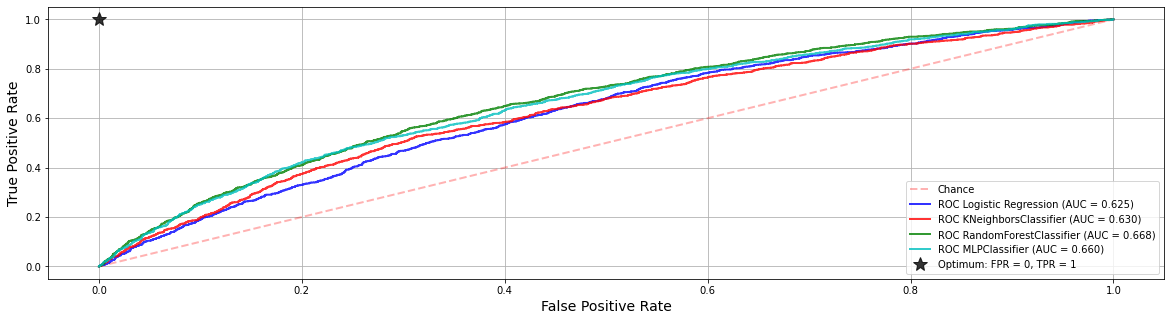

,AUC
Logistic Regression,0.625283
KNeighborsClassifier,0.630223
RandomForestClassifier,0.668394
MLPClassifier,0.660056


In [46]:
# Select ML Classifiers and Fix the HP Values to the best values found in previous iteration
# of the pipeline
names = ["Logistic Regression", "KNeighborsClassifier", "RandomForestClassifier", "MLPClassifier"]

reg_coeff = hp_values.loc["Logistic Regression","BestHP_Values"][0]

best_n_neighbors = hp_values.loc["KNeighborsClassifier","BestHP_Values"][0]

best_max_depth = hp_values.loc["RandomForestClassifier","BestHP_Values"][0]
best_max_features = hp_values.loc["RandomForestClassifier","BestHP_Values"][2]
best_min_samples_leaf = hp_values.loc["RandomForestClassifier","BestHP_Values"][1]
best_min_samples_split = hp_values.loc["RandomForestClassifier","BestHP_Values"][2]
best_n_estimators = hp_values.loc["RandomForestClassifier","BestHP_Values"][3]

best_hidden_layer_sizes = hp_values.loc["MLPClassifier","BestHP_Values"][2]
best_activation = hp_values.loc["MLPClassifier","BestHP_Values"][0]
best_solver = hp_values.loc["MLPClassifier","BestHP_Values"][4]
best_alpha = hp_values.loc["MLPClassifier","BestHP_Values"][1]
best_learning_rate = hp_values.loc["MLPClassifier","BestHP_Values"][3]

classifiers = [
    LogisticRegression(C = reg_coeff, penalty='l2', solver='lbfgs', class_weight='balanced', n_jobs=-1, random_state=42),
    KNeighborsClassifier(n_neighbors = best_n_neighbors, weights='distance', metric='manhattan', n_jobs=-1),
    RandomForestClassifier(bootstrap = True, max_depth = best_max_depth, max_features = 'sqrt', 
                           min_samples_leaf = best_min_samples_leaf, min_samples_split = best_min_samples_split,
                           n_estimators = best_n_estimators, n_jobs=-1, random_state=42, class_weight='balanced'),
    MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=best_solver,
                  alpha=best_alpha, learning_rate=best_learning_rate, random_state=42)
]


# Print Info
print(20*'*')
print('% of Class 1 in Testing : ', len(ground_truth_test[ground_truth_test == 1]) / len(ground_truth_test),
      '; % of Class 0 in Testing: ', len(ground_truth_test[ground_truth_test == 0]) / len(ground_truth_test))
print('Shape Test Set :', scaled_dataset_test.shape, ',', ground_truth_test.shape)
print(20*'*')

# Print Performance on Test Set
performance = direct_prediction(scaled_dataset, ground_truth, 
                                scaled_dataset_test, ground_truth_test, 
                                names, classifiers)

performance.head()

### Confusion Matrix

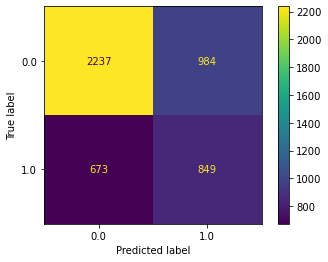

In [47]:
# Select the classifier
clf = classifiers[2] # Random Forest Classifier

# Fit the train set, predict with the test set and compare
estimator = clf.fit(scaled_dataset, ground_truth)
predictions = clf.predict(scaled_dataset_test)
cm = confusion_matrix(ground_truth_test, predictions, labels=classifiers[2].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifiers[2].classes_)
disp.plot()
plt.show()

## Keras hypertuning and perfomances

In [48]:
# Sequential Hyperparameter Tuning (https://www.tensorflow.org/tutorials/keras/keras_tuner)
X_train = dataset.to_numpy(copy=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

y_train = ground_truth.to_numpy(copy=True)

nb_of_feature = X_train.shape[1]

X_test = dataset_test.to_numpy(copy=True)
ground_truth_test = basic_test.loc[:, 'User_Satisfaction'].copy()
y_test = ground_truth_test.to_numpy(copy=True)

# Scale X_test
X_test = scaler.transform(X_test)

# model_builder
def model_builder(hp, nb_of_features=nb_of_feature, n_layers=2):
  '''
  :param nb_of_features: number of features of the dataset, used for input_shape of the first layer
  :parm nb_classes: number of label of the dataset, it will be the number of nodes of the last layer
  :param n_layer: number of layers of the model, considering the starting one and not the last one
  '''
  model = Sequential()

  for i in range(n_layers):
    # Number of nodes for the ith layer
    hp_unit = hp.Int('units'+str(i), min_value=5, max_value=150, step=5)
    
    if i==0: # first layer
      model.add(Dense(hp_unit, input_shape=(nb_of_features,), activation='sigmoid'))
    else: # hidden layers
      model.add(Dense(hp_unit, activation='sigmoid'))
      
  # last layer
  model.add(Dense(2, activation='softmax'))

  # Learning Rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=BinaryCrossentropy(from_logits=True),
                metrics=['binary_accuracy'])

  return model

# Hyperband tuner
tuner = kt.Hyperband(hypermodel=model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=10,
                     factor=3
                     )

stop_early = EarlyStopping(monitor='val_loss', patience=5)

keras_y_train = to_categorical(y_train, num_classes=2)

tuner.search(X_train, keras_y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units0')}, in the second densely-connected layer is {best_hps.get('units0')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, keras_y_train, epochs=100, validation_split=0.2)

# Find the best epoch based on val_accuracy
val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model with best_epoch
hypermodel.fit(X_train, keras_y_train, epochs=best_epoch, validation_split=0.2)

eval_result = hypermodel.evaluate(X_train, keras_y_train)
print("[test loss, test binary_accuracy]:", eval_result)

keras_y_test = to_categorical(y_test, num_classes=2)

print('Obtained accuracy of {} on the test set'.format(hypermodel.evaluate(X_test, keras_y_test)[1]))

# Retrieve predictions for further analysis
y_pred = np.argmax(hypermodel.predict(X_test), axis=1)



INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 140, in the second densely-connected layer is 140 and the optimal learning rate for the optimizer is 0.01.

Epoch 1/100


D:\Users\giaco\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:5029: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


475/475 [==============================] - 1s 2ms/step - loss: 0.6232 - binary_accuracy: 0.6722 - val_loss: 0.6115 - val_binary_accuracy: 0.6808
Epoch 2/100
475/475 [==============================] - 0s 1ms/step - loss: 0.6127 - binary_accuracy: 0.6799 - val_loss: 0.6053 - val_binary_accuracy: 0.6842
Epoch 3/100
475/475 [==============================] - 1s 1ms/step - loss: 0.6082 - binary_accuracy: 0.6825 - val_loss: 0.6083 - val_binary_accuracy: 0.6819
Epoch 4/100
475/475 [==============================] - 1s 1ms/step - loss: 0.6084 - binary_accuracy: 0.6827 - val_loss: 0.6014 - val_binary_accuracy: 0.6903
Epoch 5/100
475/475 [==============================] - 0s 974us/step - loss: 0.6061 - binary_accuracy: 0.6828 - val_loss: 0.6010 - val_binary_accuracy: 0.6885
Epoch 6/100
475/475 [==============================] - 0s 935us/step - loss: 0.6047 - binary_accuracy: 0.6823 - val_loss: 0.5997 - val_binary_accuracy: 0.6906
Epoch 7/100
475/475 [==============================] - 0s 1ms/step

475/475 [==============================] - 0s 974us/step - loss: 0.4667 - binary_accuracy: 0.7642 - val_loss: 0.7626 - val_binary_accuracy: 0.6645
Epoch 53/100
475/475 [==============================] - 0s 974us/step - loss: 0.4632 - binary_accuracy: 0.7704 - val_loss: 0.7613 - val_binary_accuracy: 0.6497
Epoch 54/100
475/475 [==============================] - 0s 974us/step - loss: 0.4578 - binary_accuracy: 0.7748 - val_loss: 0.7712 - val_binary_accuracy: 0.6529
Epoch 55/100
475/475 [==============================] - 0s 991us/step - loss: 0.4527 - binary_accuracy: 0.7719 - val_loss: 0.7986 - val_binary_accuracy: 0.6431
Epoch 56/100
475/475 [==============================] - 0s 974us/step - loss: 0.4469 - binary_accuracy: 0.7797 - val_loss: 0.7856 - val_binary_accuracy: 0.6502
Epoch 57/100
475/475 [==============================] - 0s 974us/step - loss: 0.4406 - binary_accuracy: 0.7829 - val_loss: 0.8221 - val_binary_accuracy: 0.6302
Epoch 58/100
475/475 [==============================]

475/475 [==============================] - 1s 1ms/step - loss: 0.6083 - binary_accuracy: 0.6824 - val_loss: 0.6052 - val_binary_accuracy: 0.6805
Epoch 4/6
475/475 [==============================] - 0s 1ms/step - loss: 0.6082 - binary_accuracy: 0.6829 - val_loss: 0.6015 - val_binary_accuracy: 0.6853
Epoch 5/6
475/475 [==============================] - 0s 995us/step - loss: 0.6064 - binary_accuracy: 0.6831 - val_loss: 0.6019 - val_binary_accuracy: 0.6863
Epoch 6/6
593/593 [==============================] - 0s 559us/step - loss: 0.6021 - binary_accuracy: 0.6821
[test loss, test binary_accuracy]: [0.6020894050598145, 0.6820769906044006]
149/149 [==============================] - 0s 542us/step - loss: 0.6021 - binary_accuracy: 0.6842
Obtained accuracy of 0.6841661334037781 on the test set


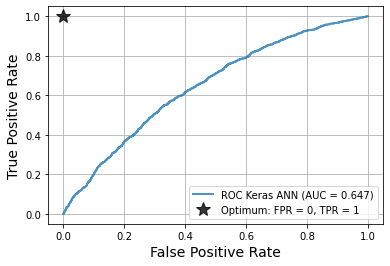

Keras ANN obtained an AUC score of 0.6472192383997755


In [49]:
prediction_proba = hypermodel.predict(X_test)[:,1]

fpr, tpr, decision_thresholds = metrics.roc_curve(y_test, prediction_proba, pos_label=1)

perf = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label=r'ROC %s (AUC = %0.3f)' % ('Keras ANN',perf), lw=2, alpha=.8)
plt.plot(0, 1, '*', color='k', label=r'Optimum: FPR = 0, TPR = 1', lw=2, alpha=.8, markersize=15)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xticks(color='black')
plt.yticks(color='black')
plt.grid(1)
plt.xlabel('False Positive Rate', color='black', fontsize=14)
plt.ylabel('True Positive Rate', color='black', fontsize=14)
plt.legend(loc="lower right")
plt.show()

print('Keras ANN obtained an AUC score of {}'.format(perf))

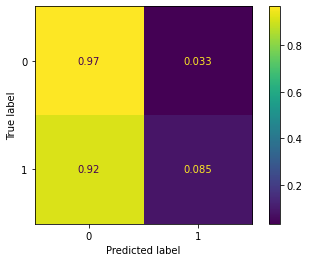

In [50]:
cm = confusion_matrix(y_test, y_pred, labels=range(2), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(2))
disp.plot()
plt.show()

# Results

#### Original Dataset
Logistic Regression 	0.62638 <br>
KNeighborsClassifier 	0.601571 <br>
RandomForestClassifier 	0.726321 <br>
MLPClassifier 	        0.644287 <br>
KerasANN                0.633728

#### Add new features
Logistic Regression 	0.628555 <br>
KNeighborsClassifier 	0.629667 <br>
RandomForestClassifier 	0.731627 <br>
MLPClassifier 	        0.658947 <br>
Keras ANN               0.664906 <br>

#### Add new Features -> Feature Selection (Method 3) -> Transform

Logistic Regression 	0.608062 <br>
KNeighborsClassifier 	0.603282 <br>
RandomForestClassifier 	0.658333 <br>
MLPClassifier 	        0.650546 <br>
KerasANN                0.644747<br>

#### Add new features -> Transformations 
Logistic Regression 	0.633349 <br>
KNeighborsClassifier 	0.67311 <br>
RandomForestClassifier 	0.731521 <br>
MLPClassifier 	        0.727184 <br>
KerasANN                0.726958

#### Add new features (no YT Time) -> Transformations 
Logistic Regression 	0.633443 <br>
KNeighborsClassifier 	0.677145 <br>
RandomForestClassifier 	0.731784 <br>
MLPClassifier 	        0.728846 <br>
KerasANN                0.725152